In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#%matplotlib notebook
%matplotlib inline

In [3]:
# delta robot param
# https://www.marginallyclever.com/other/samples/fk-ik-test.html
# https://hypertriangle.com/~alex/delta-robot-tutorial/

f = 1.0     # base edge length
e = 0.3     # end effector radius
rf = 0.5    # bizeps length
re = 1.0    # forarm length

In [4]:
def get_rf_vec(theta1, theta2, theta3):

    t=((f-e)*np.sqrt(3))/6

    # rf 1
    rf1 = np.zeros(3)
    rf1[1] = -(t + rf*np.cos(theta1))
    rf1[2] = -rf*np.sin(theta1)

    # rf 2
    rf2 = np.zeros(3)
    rf2[1] = (t + rf*np.cos(theta2))*np.sin(np.pi/6)
    rf2[0] = rf2[1]*np.tan(np.pi/3)
    rf2[2] = -rf*np.sin(theta2)

    # rf 3
    rf3 = np.zeros(3)
    rf3[1] = (t + rf*np.cos(theta3))*np.sin(np.pi/6)
    rf3[0] = -rf3[1]*np.tan(np.pi/3)
    rf3[2] = -rf*np.sin(theta3)

    return rf1, rf2, rf3


def forward(theta1, theta2, theta3):

    state = 0
    
    rf1, rf2, rf3 = get_rf_vec(theta1, theta2, theta3)

    dnm = (rf2[1]-rf1[1])*rf3[0]-(rf3[1]-rf1[1])*rf2[0]

    w1 = rf1[1]*rf1[1] + rf1[2]*rf1[2]
    w2 = rf2[0]*rf2[0] + rf2[1]*rf2[1] + rf2[2]*rf2[2]
    w3 = rf3[0]*rf3[0] + rf3[1]*rf3[1] + rf3[2]*rf3[2]

    # x = (a1*z + b1)/dnm
    a1 = (rf2[2]-rf1[2])*(rf3[1]-rf1[1])-(rf3[2]-rf1[2])*(rf2[1]-rf1[1])
    b1 = -((w2-w1)*(rf3[1]-rf1[1])-(w3-w1)*(rf2[1]-rf1[1]))/2.0
    # y = (a2*z + b2)/dnm
    a2 = -(rf2[2]-rf1[2])*rf3[0]+(rf3[2]-rf1[2])*rf2[0]
    b2 = ((w2-w1)*rf3[0] - (w3-w1)*rf2[0])/2.0

    # a*z^2 + b*z + c = 0
    a = a1*a1 + a2*a2 + dnm*dnm
    b = 2*(a1*b1 + a2*(b2-rf1[1]*dnm) - rf1[2]*dnm*dnm)
    c = (b2-rf1[1]*dnm)*(b2-rf1[1]*dnm) + b1*b1 + dnm*dnm*(rf1[2]*rf1[2] - re*re)

    d = b*b - 4.0*a*c
    if d < 0:
        return 0, 0, 0 # invalid pos

    ee_vec = np.zeros(3)
    ee_vec[2] = 0.5*(b+np.sqrt(d))/a
    ee_vec[0] = (a1*ee_vec[2] + b1)/dnm
    ee_vec[1] = (a2*ee_vec[2] + b2)/dnm

    return ee_vec

In [5]:
# rot matrix in z (120° = 2π/3)
rot_z_120 = np.array([
    [np.cos(2*np.pi/3),   -np.sin(2*np.pi/3), 0],
    [np.sin(2*np.pi/3),    np.cos(2*np.pi/3), 0],
    [0,                     0,                1]
])

In [6]:
def calcAngleYZ(pos):

    y1 = -(f*np.sqrt(3))/6
    y0 = pos[1] - (e*np.sqrt(3))/6

    a = (pos[0]*pos[0] + y0*y0 + pos[2]*pos[2] + rf*rf - re*re - y1*y1)/(2*pos[2])
    b = (y1-y0)/pos[2]

    # discriminant
    d = -(a+b*y1)*(a+b*y1)+rf*(b*b*rf+rf)
    
    if d < 0:
        return 0    # Singularity
    
    yj = (y1 - a*b - np.sqrt(d))/(b*b + 1)
    zj = a + b*yj

    theta = np.arctan(-zj/(y1-yj))
    
    if yj>y1:
        theta += np.pi
    return theta


def inverse(pos):

    angles = np.zeros(3)
    angles[0] = calcAngleYZ(pos)
    angles[1] = calcAngleYZ(np.dot(rot_z_120, pos))    # rotate +120 deg
    angles[2] = calcAngleYZ(np.dot(rot_z_120.T, pos))  # rotate -120 deg
    return angles


In [7]:
def draw_forward(angles, draw_tcp_cart=False):
    
    plt.figure(figsize=(10,10))
    axlim = [-1.5, 1.5]
    ax = plt.axes(projection='3d')

    """
             A                      
            /|\                 
           / | \
       F3 /  |  \ F2
         /   O   \
        /    |    \
       /_____|_____\
      B      F1     C 
      |------f------|
            
        O = (0|0|0)

    """

    # ---- BASE ------
    # calc base vectors
    OA = (f*np.sqrt(3))/3
    OF = (f*np.sqrt(3))/6

    # triangle corner
    A = np.array([0, OA, 0])
    B = np.dot(rot_z_120, A)
    C = np.dot(rot_z_120.T, A)

    # triangle edge center
    F1_b = np.array([0, -OF, 0])
    F2_b = np.dot(rot_z_120, F1_b)
    F3_b = np.dot(rot_z_120.T, F1_b)

    # draw base triangle
    ax.plot([A[0], B[0]], [A[1], B[1]], [A[2], B[2]], color="black", linewidth=2)
    ax.plot([B[0], C[0]], [B[1], C[1]], [B[2], C[2]], color="black", linewidth=2)
    ax.plot([C[0], A[0]], [C[1], A[1]], [C[2], A[2]], color="black", linewidth=2)

    # draw base center
    ax.plot([0, A[0]], [0, A[1]], [0, A[2]], color="orange", linestyle="--", linewidth=1)
    ax.plot([0, B[0]], [0, B[1]], [0, B[2]], color="orange", linestyle="--", linewidth=1)
    ax.plot([0, C[0]], [0, C[1]], [0, C[2]], color="orange", linestyle="--", linewidth=1)

    # draw base circle
    t = np.linspace(0, 2*np.pi)
    ax.plot(np.sin(t)*OF, np.cos(t)*OF, 0, color="orange", linestyle="--", linewidth=1)

    # draw joints (F)
    ax.scatter(F1_b[0], F1_b[1], F1_b[2], color="black")
    ax.scatter(F2_b[0], F2_b[1], F2_b[2], color="black")
    ax.scatter(F3_b[0], F3_b[1], F3_b[2], color="black")
    
    # ---- TCP -------
    # calc tcp vectors
    ee_pos = forward(angles[0], angles[1], angles[2])
    shift = np.copy(ee_pos)
    shift[2] = 0
    
    OA = (e*np.sqrt(3))/3
    OF = (e*np.sqrt(3))/6
    
    # draw rectange in center (0|0|0) then shift bei ee_pos
    # triangle corner
    A = np.array([0, OA, -ee_pos[2]])
    B = np.dot(rot_z_120, A)
    C = np.dot(rot_z_120.T, A)
    A -= shift
    B -= shift
    C -= shift

    # triangle edge center
    F1_e = np.array([0, -OF, -ee_pos[2]])
    F2_e = np.dot(rot_z_120, F1_e)
    F3_e = np.dot(rot_z_120.T, F1_e)
    F1_e -= shift
    F2_e -= shift
    F3_e -= shift

    # draw end effector triangle
    ax.plot([A[0], B[0]], [A[1], B[1]], [A[2], B[2]], color="black", linewidth=2)
    ax.plot([B[0], C[0]], [B[1], C[1]], [B[2], C[2]], color="black", linewidth=2)
    ax.plot([C[0], A[0]], [C[1], A[1]], [C[2], A[2]], color="black", linewidth=2)

    # draw endeffector center
    ax.scatter(-ee_pos[0], -ee_pos[1], -ee_pos[2], color="red")

    # draw joints (E)
    ax.scatter(F1_e[0], F1_e[1], F1_e[2], color="black")
    ax.scatter(F2_e[0], F2_e[1], F2_e[2], color="black")
    ax.scatter(F3_e[0], F3_e[1], F3_e[2], color="black")
    
    # ---- ARMS ------
    # rf vectors aka bizeps
    rf1, rf2, rf3 = get_rf_vec(angles[0], angles[1], angles[2])
    ax.plot([F1_b[0], rf1[0]], [F1_b[1], rf1[1]], [F1_b[2], rf1[2]], color="black", linewidth=2)
    ax.plot([F2_b[0], rf2[0]], [F2_b[1], rf2[1]], [F2_b[2], rf2[2]], color="black", linewidth=2)
    ax.plot([F3_b[0], rf3[0]], [F3_b[1], rf3[1]], [F3_b[2], rf3[2]], color="black", linewidth=2)
    
    # draw joints (J)
    ax.scatter(rf1[0], rf1[1], rf1[2], color="black")
    ax.scatter(rf2[0], rf2[1], rf2[2], color="black")
    ax.scatter(rf3[0], rf3[1], rf3[2], color="black")

    # draw re vector aka forarm
    ax.plot([rf1[0],F1_e[0]], [rf1[1],F1_e[1]], [rf1[2],F1_e[2]], color="black", linewidth=2)
    ax.plot([rf2[0],F2_e[0]], [rf2[1],F2_e[1]], [rf2[2],F2_e[2]], color="black", linewidth=2)
    ax.plot([rf3[0],F3_e[0]], [rf3[1],F3_e[1]], [rf3[2],F3_e[2]], color="black", linewidth=2)

    # draw end effector triangle
    ax.plot([A[0], B[0]], [A[1], B[1]], [A[2], B[2]], color="black", linewidth=2)
    ax.plot([B[0], C[0]], [B[1], C[1]], [B[2], C[2]], color="black", linewidth=2)
    ax.plot([C[0], A[0]], [C[1], A[1]], [C[2], A[2]], color="black", linewidth=2)

    # draw tcp cart
    if draw_tcp_cart:
        length = 0.4
        ee_pos *= -1
        ax.plot([ee_pos[0],ee_pos[0]+length], [ee_pos[1],ee_pos[1]], [ee_pos[2],ee_pos[2]], color="red", linewidth=1)
        ax.plot([ee_pos[0],ee_pos[0]], [ee_pos[1],ee_pos[1]+length], [ee_pos[2],ee_pos[2]], color="green", linewidth=1)
        ax.plot([ee_pos[0],ee_pos[0]], [ee_pos[1],ee_pos[1]], [ee_pos[2],ee_pos[2]+length], color="blue", linewidth=1)

    ax.set_box_aspect(aspect=(1, 1, 0.5), zoom=0.90)
    ax.set_xlim(axlim)
    ax.set_xlabel('$X$', fontsize=14)
    ax.set_ylim(axlim)
    ax.set_ylabel('$Y$', fontsize=14)
    ax.set_zlim(axlim[0], 0)
    ax.set_zlabel('$Z$', fontsize=14)

    #ax.invert_zaxis()
    #ax.view_init(elev=90, azim=0, roll=0)
    return plt

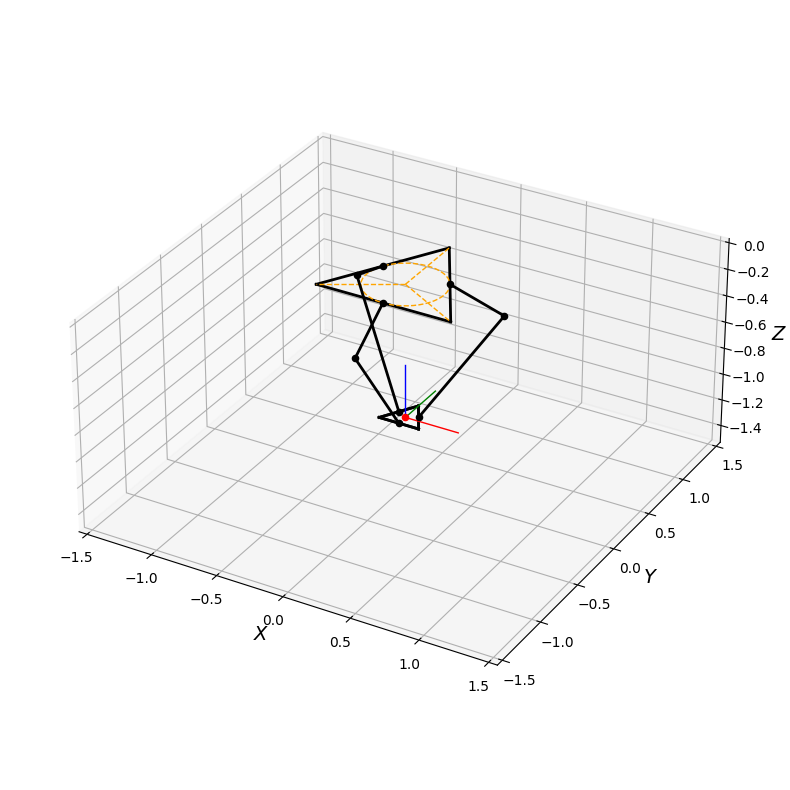

In [8]:
draw_forward(inverse([0,0,-1]), True).show()

<img src="images/rot_x-axis.gif" alt="drawing" width="600"/>
<img src="images/rot_y-axis.gif" alt="drawing" width="600"/>
<br>
<img src="images/rot_z-axis.gif" alt="drawing" width="600"/>
<img src="images/rot_circle.gif" alt="drawing" width="600"/>

In [9]:
# make gif
#pos = np.array([0, 0, -1])
#angles = inverse(pos)

#angles = np.linspace(0, 2*np.pi, 50)

#for i in range(len(angles)):
#    frame = draw_forward(inverse([np.sin(angles[i])*0.3, np.cos(angles[i])*0.3, -.5]))
#    frame.savefig(f"tmp/{i}.png")